In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from scipy.integrate import quad, solve_ivp

In [45]:
class IsotermAdsorption:
    
    @staticmethod
    def langmuir(Ce: float, qml: float, Kl: float):
        return qml*Kl*Ce/(1+Kl*Ce)
    
    @staticmethod
    def freundlich(Ce: float, Kf: float, nf: float):
        return Kf*Ce**(1/nf)
    
    @staticmethod
    def plot_isoterm(isoterm: Callable, dict_isoterm: dict, Ce:float, n_point=100, x_unit:str=None, y_unit: str=None):
        Ce = np.linspace(0,Ce,n_point)
        q = isoterm(Ce, **dict_isoterm)
        
        x_label = "Concentração"
        if x_unit:
            x_label = "%s (%s)" %(x_label, x_unit)
        y_label = "Capacidade de Adsorção"
        if y_unit:
            y_label = "%s (%s)" %(y_label, y_unit)
            
        plt.plot(Ce, q)          
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title("Isoterma de %s" % isoterm.__name__)
        plt.grid()

In [46]:
class KineticsAdorption:
    
    @staticmethod
    def first_order(q, qe, k):
        return k*(qe- q)
    
    @staticmethod
    def second_order(q, qe, k):
        return k*(qe- q)**2
    
    @staticmethod
    def plot_kinetics(kinetics: Callable, dict_kinetics: dict, time:float, n_point=100, x_unit:str=None, y_unit: str=None):
        res = solve_ivp(lambda t,y : kinetics(y[0], **dict_kinetics), (0,time), [0], max_step=0.1)
        
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" %(x_label, x_unit)
        y_label = "Capacidade de Adsorção"
        if y_unit:
            y_label = "%s (%s)" %(y_label, y_unit)
            
        plt.plot(res.t, res.y[0])          
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        name = kinetics.__name__.split("_")[0]
        name = KineticsAdorption.__translate(name)
        plt.title("Cinética de pseudo %s ordem" % name)
        plt.grid()
        
    @staticmethod
    def __translate(name: str):
        dict_tranlate={"first": "primeira", "second": "segunda"}
        response = dict_tranlate[name]
        return response

In [47]:
class AdsorptionTank:
    def __init__(self, isoterm: Callable, dict_isoterm: dict, knetics: Callable, dict_knetics: dict):
        self.isoterm = isoterm
        self.dict_isoterm = dict_isoterm
        self.knetics = knetics
        self.dict_knetics = dict_knetics
        self.concentration = None
        self.adsorption_capacity = None
        self.time = None
    
    @staticmethod
    def __edo(t, y, isoterm, dict_isoterm, knetics, dict_knetics, mass_adsorption, volume) -> list:
        c = y[0]
        q = y[1]
        qe = isoterm(c,**dict_isoterm)
        dq = knetics(q, qe, **dict_knetics)
        dc = -dq*mass_adsorption/volume
    
        return [dc, dq]
    
    def calculate_concentration(self, concentration, mass_adsorption, volume, time, inplace=True)-> Tuple[np.array, np.array]:
        res = solve_ivp(AdsorptionTank.__edo, (0,time), (concentration, 0), max_step=0.1,
                        args=(self.isoterm, self.dict_isoterm, self.knetics, self.dict_knetics, mass_adsorption, volume))
        if inplace:
            self.concentration = res.y[0]
            self.adsorption_capacity = res.y[1]
            self.time = res.t
        
        return res.t, res.y[0]
    
    def plot_concentration(self, x_unit:str= None, y_unit:str=None):
        plt.plot(self.time,self.concentration)
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" % (x_label, x_unit)
        y_label =  "Concentração"   
        if y_unit:
            y_label = "%s (%s)" % (y_label, y_unit)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title("Concentração vs Tempo")
        plt.grid()
        
    def plot_recovery(self, x_unit:str= None):
        recovery = 1 - self.concentration/self.concentration[0]
        plt.plot(self.time,recovery)
        x_label = "Tempo"
        if x_unit:
            x_label = "%s (%s)" % (x_label, x_unit)
        plt.xlabel(x_label)
        plt.ylabel("Porcentagem de Recuperação")
        plt.title("Recuperação vs Tempo")
        plt.grid()

In [48]:
isoterm_dict = {'qml': 120.48, 'Kl': 1.59e-2}
kinetics_dic = {'k': .12}
tank = AdsorptionTank(IsotermAdsorption.langmuir, isoterm_dict, KineticsAdorption.second_order, knetics_dic)
t, c = tank.calculate_concentration(100, 2, 1, 5)

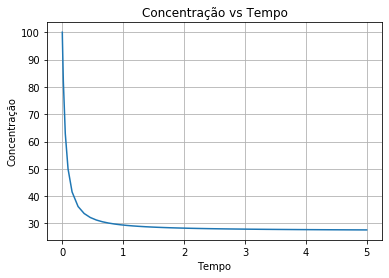

In [49]:
tank.plot_concentration()

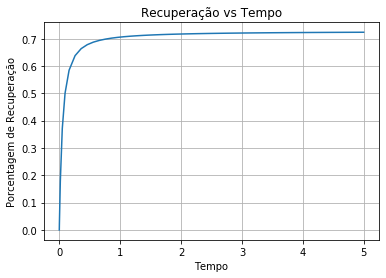

In [50]:
tank.plot_recovery()